In [2]:
import os
import sys
import importlib
import glob
import time
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.RationalApproximation import RationalApproximation_AAA
from scipy.special import gamma 
import scipy
from scipy.integrate import solve_ivp

import pandas as pd 

In [3]:
class MultiTermKernel: 

    def __init__(self, phis, alphas, **kwargs):
        self.phis = phis
        self.alphas = alphas

        self.RATarget = np.vectorize(self.eval_RATarget) 
        self.kernel = np.vectorize(self.eval_kernel)

    def eval_kernel(self, t):
        return np.sum(self.phis / gamma(1 - self.alphas) * t **(-self.alphas))
    
    def eval_RATarget(self, t):
        return np.sum(self.phis * t ** (1 - self.alphas))
    
# Distribution phi 
@np.vectorize
def Distribution(alpha): 
    return gamma(6 - alpha) / 120

# Right side of the equation 
@np.vectorize
def f(t): 
    if t == 0: 
        return 0
    if t == 1: 
        return 2
    return (t ** 5 - t**3) / np.log(t)

# Analytical solution 
@np.vectorize
def sol_u(t): 
    return t ** 5

@np.vectorize
def sol_v(t): 
    return 5 * t**4 

# Analytical solution modes 
@np.vectorize
def sol_modes(t, a, w): 
    # w = weights 
    # a = poles 
    # the constant is chosen such that the modes have initial condition u_k(0)=0
    c = 120 * w / a ** 6 
    return (w * (- 120        / a**6 
                 + 120 * t**1 / a**5 
                 - 60  * t**2 / a**4 
                 + 20  * t**3 / a**3 
                 - 5   * t**4 / a**2 
                 + 1   * t**5 / a) 
                 + c * np.exp(-a*t))

In [4]:
class ODE_problem: 
    def __init__(self,beta0, beta1, beta2, poles01, weights01, poles12, weights12): 

        self.beta0 = beta0
        self.beta1 = beta1
        self.beta2 = beta2
        
        self.poles01 = poles01
        self.weights01 = weights01
        self.m01 = self.poles01.shape[0]

        self.poles12 = poles12
        self.weights12 = weights12
        self.m12 = self.poles12.shape[0]

        self.fun = np.vectorize(self.eval)

    def eval(self, t,y):
        # 0 -> u
        # 1 -> dt u 
        # 01 modes 
        # 12 modes 

        x = 0 * y

        # Derivative of u: 1 -
        x[0] = y[1]

        # Main equation  
        x[1] = -1 / self.beta2 * (self.beta0 * y[0] + self.beta1 * y[1] 
                                  - np.sum(self.poles01 * y[2:self.m01+2])
                                  + np.sum(self.poles12 ** 2 * y[self.m01+2:self.m01+self.m12+2])
                                  - f(t))

        # Mode equations 01 
        x[2:self.m01+2] = - self.poles01 * y[2:self.m01+2] + self.weights01 * y[0]

        # Mode equations 12 
        x[self.m01+2:self.m01+self.m12+2] = - self.poles12 * y[self.m01+2:self.m01+self.m12+2] + self.weights12 * y[0]

        return x 

In [5]:
#########################################
### Quadrature of the integral 
#########################################

n_QF = 2 ** 20

# interval length / (n for 0 to 1 + n for 1 to 2 + 3 for 0,1,2)
QFweight = 2 / (2*n_QF+3)
quadraturePoints01 = np.arange(0 + 0.5/n_QF,1 + 0.5/n_QF, 1/n_QF)
quadraturePoints12 = np.arange(1 + 0.5/n_QF,2 + 0.5/n_QF, 1/n_QF)

phis01 = Distribution(quadraturePoints01) * QFweight
phis12 = Distribution(quadraturePoints12) * QFweight
phi0 = Distribution(0) * QFweight
phi1 = Distribution(1) * QFweight
phi2 = Distribution(2) * QFweight

MTK01 = MultiTermKernel(phis01,quadraturePoints01)
MTK12 = MultiTermKernel(phis12,quadraturePoints12-1)

In [37]:
#########################################
### Simulation and error  
#########################################

# dts = [1e-2 * 2 ** (-i) for i in range(11)]
T  = 1
dts = [0.1 * 10**-i for i in range(8)]

error_u = [] 

for idx, dt in enumerate(dts): 

    print(idx," - ",dt)
    n_timesteps = int(np.round(T/dt)) + 1
    t = dt * np.asarray(range(n_timesteps))   

    #########################################
    ### Rational Approximation of the Integral Kernel
    #########################################

    Zmin, Zmax = 1/T,1/dt
    tol = 1.e-10
    MaxDegree = 30
    nSupportPoints = 100

    RA01 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                    TargetFunction=MTK01.RATarget)
    RA12 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                    TargetFunction=MTK12.RATarget)

    weights01 = RA01.c
    poles01 = RA01.d
    winf01 = RA01.c_inf
    m01 = weights01.shape[0]

    weights12 = RA12.c
    poles12 = RA12.d
    winf12 = RA12.c_inf
    m12 = weights12.shape[0]

    beta0 = phi0 + np.sum(weights01) - np.sum(weights12 * poles12)
    beta1 = phi1 + np.sum(weights12) + winf01
    beta2 = phi2 + winf12

    #########################################
    ### Numerical Scheme 
    #########################################

    problem = ODE_problem(beta0, beta1, beta2, poles01, weights01, poles12, weights12)
    initial = np.zeros(10)  

    t_span = (0.,1.)
    y0 = [0] * (m01+m12+2)
    
    sol = solve_ivp(problem.eval, t_span, y0, method='BDF', max_step=dt)# , atol = 1e-8, rtol = 1e-8)

    #########################################
    ### Compute error 
    #########################################

    error_u.append(dt * np.linalg.norm(sol_u(sol.t) - sol.y[0]))

    # u_list.append(u)
    # v_list.append(v)
    # a_list.append(a)

    # error_u.append(dt * (np.linalg.norm(sol_u(t) - u)))
    # error_v.append(dt * (np.linalg.norm(sol_v(t) - v)))

    # for i in range(m01): 
    #     error_modes01[idx, i] = dt * (np.linalg.norm(modes01[:,i] - sol_modes(t, poles01[i], weights01[i])))
        
    # for i in range(m12): 
    #     error_modes12[idx, i] = dt * (np.linalg.norm(modes12[:,i] - sol_modes(t, poles12[i], weights12[i])))
    

0  -  0.1
1  -  0.010000000000000002
2  -  0.001
3  -  0.0001
4  -  1e-05
5  -  1.0000000000000002e-06
6  -  1e-07
7  -  1e-08


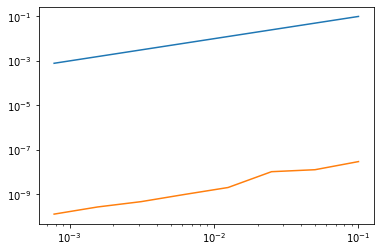

In [ ]:
plt.loglog(dts,dts)
plt.loglog(dts,error_u)

(51,)

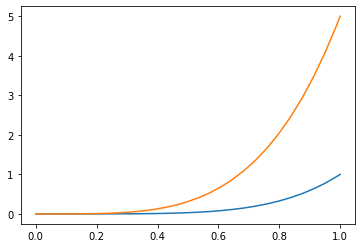

In [ ]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])

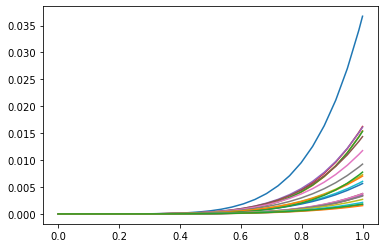

In [ ]:
for i in range(2, sol.y.shape[0]): 
    plt.plot(sol.t, sol.y[i])